# Topic modeling

In [2]:
import pandas as pd
import joblib
import os
import numpy as np
from scipy.stats import rankdata
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import InconsistentVersionWarning
import warnings
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

import stylia
from stylia import TWO_COLUMNS_WIDTH
from stylia.colors import ContinuousColorMap
import stylia.colors

base_results_path = "../results/topicmodeling"
results_path = os.path.abspath(os.path.join(base_results_path, "all_outcomes_all_genes"))

print(f"Results path: {results_path}")


Results path: /Users/mduranfrigola/Documents/GitHub/pharmacogx-embeddings/results/topicmodeling/all_outcomes_all_genes


In [3]:
def tokenizer(x):
    return x.split(" ")

topic_data = joblib.load(os.path.join(results_path, "topic_data.joblib"))
processed_topicwizard_data = joblib.load(os.path.join(results_path, "processed_topicwizard_data.joblib"))

topic_names = topic_data["topic_names"]

df = pd.read_csv(os.path.join(results_path, "CompoundHasTopic.csv"))

cmap = ContinuousColorMap()
cmap.fit([i for i in range(len(topic_names))])
topic_colors = cmap.transform([i for i in range(len(topic_names))])

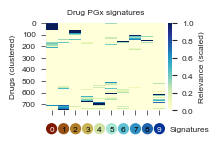

In [15]:
import random
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

w = TWO_COLUMNS_WIDTH/(TWO_COLUMNS_WIDTH/1.5 - TWO_COLUMNS_WIDTH/5)
fig, axs = stylia.create_figure(2, 1, width=w, height=TWO_COLUMNS_WIDTH/5, height_ratios=[6,1])

ax = axs.next()

W = processed_topicwizard_data["document_topic_matrix"]

W = sklearn.preprocessing.MinMaxScaler().fit_transform(W)
W[W < 0.1] = 0

ax.set_yticks([i for i in range(len(topic_names))])
ax.set_ylim(len(topic_names), -1)

Z = hierarchy.ward(W)
hierarchy.leaves_list(Z)
clustered_idxs = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, W))

sns.heatmap(W[clustered_idxs], ax=ax, cmap="YlGnBu", cbar_kws={'label': "Relevance (scaled)", "pad": 0.02})
yticks = np.arange(0, 800, 100)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xticks([i+0.5 for i in range(len(topic_names))])
ax.set_xticklabels("")

stylia.label(ax=ax, title="Drug PGx signatures", ylabel="Drugs (clustered)", xlabel="")

ax = axs.next()

topic_importances = processed_topicwizard_data["topic_importances"]
ax.scatter([i for i in range(len(topic_importances))], [0]*len(topic_importances), s=50, color=topic_colors)
for i in range(len(topic_importances)):
    if i == 0 or i == 9:
        c = "white"
    else:
        c = "black"
    ax.text(i, 0, i, ha="center", va="center", fontsize=6, color=c)
ax.set_axis_off()
ax.set_xlim(-0.5, 11.5)

ax.text(11.5, 0, "Signatures", ha="center", va="center", fontsize=6)

stylia.label(ax=ax, title="", xlabel="", ylabel="", abc="")
stylia.save_figure(os.path.join("assets", "drug_pgx_signatures.png"))
stylia.save_figure(os.path.join("assets", "drug_pgx_signatures.pdf"))

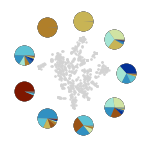

In [8]:
fig, axs = stylia.create_figure(1, 1, width=TWO_COLUMNS_WIDTH/5, height=TWO_COLUMNS_WIDTH/5)

do_label = False

cids = topic_data["document_names"]

num_compounds = 9

sel_cids = random.sample(cids, num_compounds)
sel_cids_idxs = [cids.index(f) for f in sel_cids]
phis = np.linspace(0, 2*np.pi, num_compounds+1)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 100)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 100)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color, 'lw':0})

    for marker in markers:
        ax.scatter(xs, ys, **marker, zorder=10000)
        ax.scatter(xs, ys, color="gray", s=200, lw=0)

S = np.array([list(pol2cart(1.5, phi)) for phi in phis])

ax = axs.next()
P = np.array(df[["proj_x", "proj_y"]])
P = MinMaxScaler(feature_range=(-1,1)).fit_transform(P)
ax.scatter(P[:,0], P[:,1], color="lightgray", s=0.5)
ax.scatter(S[:,0], S[:,1])

if do_label:
    for cidx in sel_cids_idxs:
        ax.text(P[cidx, 0], P[cidx, 1], cids[cidx])

W = processed_topicwizard_data["document_topic_matrix"]
for i in range(S.shape[0]-1):
    r = S[i]
    v = W[i,:]
    v = v / np.sum(v)
    v = v*1000
    np.floor(v)
    v = v/1000
    v = v*0.99
    idxs = np.argsort(v)[::-1]
    v = [v[i] for i in idxs]
    c = [topic_colors[i] for i in idxs]
    drawPieMarker([r[0]], [r[1]], v, sizes=[200], colors=c, ax=ax)
    if r[1] >= 0:
        dl = 0.42
    else:
        dl = -0.42
    if do_label:
        ax.text(r[0], r[1] + dl, sel_cids[i], va="center", ha="center")
    
ax.grid(False)
ax.set_axis_off()
ax.set_xlim(-1.8,1.8)
ax.set_ylim(-1.8,1.8)
stylia.label(ax=ax, title="", xlabel="", ylabel="")

if do_label:
    sufix = "_label"
else:
    sufix = ""

stylia.save_figure(os.path.join("assets", f"drug_pgx_signatures_map{sufix}.png"))
stylia.save_figure(os.path.join("assets", f"drug_pgx_signatures_map{sufix}.pdf"))

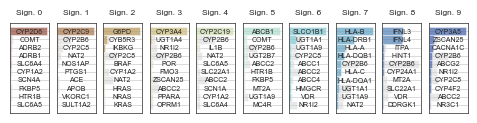

In [25]:
import matplotlib.pyplot as plt

num_proteins = 10

def topic_has_protein_barplot(ax, i):
    topic_name = "Topic {0}".format(i)
    pht = pd.read_csv(os.path.join(results_path, "ProteinHasTopic.csv"))
    pht = pht.sort_values(by=topic_name, ascending=False).head(num_proteins)
    vals = np.array(pht[topic_name])
    gvals = np.array(pht["importance"])
    idxs = [i for i in range(num_proteins)]
    ax.barh(idxs, gvals, lw=0.5, color="lightgray", height=1, alpha=0.5, edgecolor="white")
    ax.barh(idxs, vals, lw=0.5, color=topic_colors[topic_names.index(topic_name)], height=1, alpha=0.5, edgecolor="white")
    xlim = ax.get_xlim()
    ax.set_ylim(len(vals), -1)
    ax.set_title(topic_name.replace("Topic", "Sign."))
    ax.set_yticks([i for i in range(num_proteins)])
    if topic_name == "Topic 0":
        ax.set_yticklabels("")
        ax.set_ylabel("")
    else:
        ax.set_yticklabels("")
        ax.set_ylabel("")
    for i, l in enumerate(pht["gene_name"].tolist()):
        ax.text(xlim[1]*0.5, i, l, ha="center", va="center")
    #ax.set_yticklabels(pht["gene_name"])
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.tick_params(axis="y", length=0)
    
    
fig, axs = stylia.create_figure(1, 10, width=TWO_COLUMNS_WIDTH/1.5, height=TWO_COLUMNS_WIDTH/6)
for i in range(10):
    ax = axs.next()
    topic_has_protein_barplot(ax, i)
plt.tight_layout()

stylia.save_figure("assets/signature_genes.png")
stylia.save_figure("assets/signature_genes.pdf")

# Proteins map

In [27]:
df = pd.read_csv(os.path.join(results_path, "ProteinHasTopic.csv"))

x = df["proj_x"]
y = df["proj_y"]

df = df[["gene_name", "importance", "proj_x", "proj_y"]]

adme_genes = pd.read_csv(os.path.abspath(os.path.join("..", "data", "of_interest", "adme_gene_list.tsv")), sep="\t")
is_adme = []
for g in list(df["gene_name"]):
    if g in list(adme_genes["Gene Symbol"]):
        is_adme.append(1)
    else:
        is_adme.append(0)
df["is_adme"] = is_adme

vt = {}
va = {}
vs = {}
dv = pd.read_csv(os.path.abspath(os.path.join("..", "data", "variants", "1000_Genomes", "subset_snvs_protein_coding_1kGPhg38_gene_level.tsv")), sep="\t")
for v in dv[["gene", "total_variants", "afr_abundant_variants", "afr_specific_variants"]].values:
    vt[v[0]] = v[1]
    va[v[0]] = v[2]
    vs[v[0]] = v[3]

vt_list = []
va_list = []
vs_list = []
for g in list(df["gene_name"]):
    if g in vt:
        v0 = vt[g]
    else:
        v0 = 0
    if g in va:
        v1 = va[g]
    else:
        v1 = 0
    if g in vs:
        v2 = vs[g]
    else:
        v2 = 0
    vt_list.append(v0)
    va_list.append(v1)
    vs_list.append(v2)

df["total_variants"] = vt_list
df["afr_abundant_variants"] = va_list
df["afr_specific_variants"] = vs_list
df["total_variants_perc"] = rankdata(df["total_variants"], method="ordinal")/df.shape[0]*100
df["afr_abundant_variants_perc"] = rankdata(df["afr_abundant_variants"], method="ordinal")/df.shape[0]*100
df["afr_specific_variants_perc"] = rankdata(df["afr_specific_variants"], method="ordinal")/df.shape[0]*100
df.sort_values(by="importance", ascending=False, inplace=True)

### Important genes

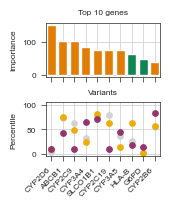

In [48]:
num_genes = 10
named_colors = stylia.colors.colors.NamedColors()
colors = [named_colors.orange if i == 1 else named_colors.green for i in df["is_adme"]]

w = TWO_COLUMNS_WIDTH/2.15 - TWO_COLUMNS_WIDTH/3.5
fig, axs = stylia.create_figure(2, 1, width=w*1.3, height=TWO_COLUMNS_WIDTH/3.5)
ax = axs.next()
ax.bar(x = [i for i in range(num_genes)], height = df["importance"].tolist()[:num_genes], color=colors, edgecolor="white")
stylia.label(ax=ax, title="Top {0} genes".format(num_genes), xlabel="", ylabel="Importance")
ax.set_xticks([i for i in range(num_genes)])
ax.set_xticklabels([])
ax.set_ylim(-5, 159)
ax.set_xlim(-0.5, num_genes-0.5)
plt.tight_layout()

ax = axs.next()
for i, v in enumerate(df[["gene_name", "total_variants_perc"]].values[:num_genes]):
    ax.scatter([i], [v[1]], color=named_colors.gray, s=15)
for i, v in enumerate(df[["gene_name", "afr_abundant_variants_perc"]].values[:num_genes]):
    ax.scatter([i], [v[1]], color=named_colors.yellow, s=15)
for i, v in enumerate(df[["gene_name", "afr_specific_variants_perc"]].values[:num_genes]):
    ax.scatter([i], [v[1]], color=named_colors.purple, s=15)

ax.set_xticks([i for i in range(num_genes)])
ax.set_xticklabels(df["gene_name"].tolist()[:num_genes], rotation=45, ha="right")

ax.set_ylim(-5, 105)
ax.set_xlim(-0.5, num_genes-0.5)
stylia.label(ax=ax, title="Variants".format(num_genes), xlabel="", ylabel="Percentile")

plt.tight_layout()

stylia.save_figure("assets/top_signature_genes_with_variants.png")
stylia.save_figure("assets/top_signature_genes_with_variants.pdf")


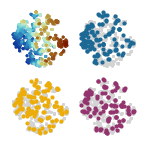

In [50]:
fig, axs = stylia.create_figure(2, 2, width=TWO_COLUMNS_WIDTH/3.5*0.7, height=TWO_COLUMNS_WIDTH/3.5*0.7)

ax = axs.next()
x = df["proj_x"]
y = df["proj_y"]
ax.scatter(x, y, color=named_colors.gray, s=1)
z = df["importance"]
cmap = stylia.colors.colors.ContinuousColorMap()
cmap.fit(z)
colors = cmap.transform(z)
ax.scatter(x, y, color=colors, s=1)
ax.set_axis_off()
stylia.label(ax=ax, title="", xlabel="", ylabel="")

ax = axs.next()
x = df["proj_x"]
y = df["proj_y"]
ax.scatter(x, y, color="lightgray", s=1)
x = df[df["is_adme"] == 1]["proj_x"]
y = df[df["is_adme"] == 1]["proj_y"]
ax.scatter(x, y, color=named_colors.blue, s=3)
ax.set_axis_off()
stylia.label(ax=ax, title="", xlabel="", ylabel="")

ax = axs.next()
x = df["proj_x"]
y = df["proj_y"]
ax.scatter(x, y, color=named_colors.gray, s=1)
z = df["afr_abundant_variants_perc"]
cmap = stylia.colors.colors.ContinuousColorMap()
cmap.fit(z)
colors = cmap.transform(z)
idxs = []
for i, v in enumerate(z):
    if v > 90:
        idxs.append(i)
ax.scatter([x[i] for i in idxs], [y[i] for i in idxs], color=named_colors.yellow, s=3)
ax.set_axis_off()
stylia.label(ax=ax, title="", xlabel="", ylabel="")

ax = axs.next()
x = df["proj_x"]
y = df["proj_y"]
ax.scatter(x, y, color=named_colors.gray, s=1)
z = df["afr_specific_variants_perc"]
cmap = stylia.colors.colors.ContinuousColorMap()
cmap.fit(z)
colors = cmap.transform(z)
idxs = []
for i, v in enumerate(z):
    if v > 90:
        idxs.append(i)
ax.scatter([x[i] for i in idxs], [y[i] for i in idxs], color=named_colors.purple, s=3)
ax.set_axis_off()
stylia.label(ax=ax, title="", xlabel="", ylabel="")

plt.tight_layout()
stylia.save_figure("assets/signature_genes_map.png")
stylia.save_figure("assets/signature_genes_map.pdf")
